In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import open3d as o3d
import nibabel as nib
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.transforms as mtransforms

INFO - 2022-01-17 16:11:16,556 - utils - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-01-17 16:11:16,558 - utils - NumExpr defaulting to 8 threads.


In [2]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'name': 'time',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif', 
                   'name': 'time',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif', 
                    'name': 'time',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}


# Data import and partition

## Preprocessed data import
The data have already been preprocessed using the matlab class PSM (using the generateExportData function).

In [14]:
# Load vectorized VTA matrix
eps = 1e-6
data = scipy.io.loadmat('data.mat')
X = np.array(data['X'])
y = np.array(data['y'])
y = np.log((y+eps)/(1-y+eps))

# Load template container
container = nib.load('container.nii')

# Load STN polygon
pcd_read = o3d.io.read_point_cloud('templates/anatomyDISTALminimal.ply')

# Assign global variable
CONTAINER_AFFINE = container.affine
CONTAINER_SHAPE = container.shape

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO - 2022-01-17 16:25:16,936 - batteryrunners - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## Create partitions of training and testing sets
The dataset is now split into the training and the testing set. In this script, no cross-validation will be performed.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [16]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a vector into tensor based on the container shape

    intercept = vector[0]
    vector = vector[1:]
    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, intercept

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [17]:
# Function used to visualize the different models
def plot_map(model,
             dim='2D', 
             plane='axial', 
             slice_index=int(CONTAINER_SHAPE[2]/2),
             view_angle=320, 
             marker='dot'):

    coef_tensor, coef_intercept = reconstruct(model.coef_)

    if dim == '2D':
        plot_slice(coef_tensor, slice_index, plane)
        
    elif dim == '3D':
        plot_cube(coef_tensor, view_angle, marker)


def plot_slice(tensor, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    
    if plane == 'axial':
        plt.imshow(tensor[:, :, slice_index], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        plt.imshow(tensor[:, slice_index, :], cmap='coolwarm')
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        plt.imshow(tensor[slice_index, :, :], cmap='coolwarm')
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_cube(cube, view_angle, marker):

    colors = cm.viridis(cube)
    alpha = normalize(np.power(np.abs(cube), 0.001))

    show_histogram(alpha)
    xx, yy, zz = np.indices(np.array(cube.shape))

    xx = xx.flatten()
    yy = yy.flatten()
    zz = zz.flatten()
    alpha = alpha.flatten()

    plt.figure(figsize=(20/2.54, 20/2.54))

    ax = plt.axes(projection='3d')
    ax.view_init(30, view_angle)
    ax.set_xlim(right=CONTAINER_SHAPE[0])
    ax.set_ylim(top=CONTAINER_SHAPE[1])
    ax.set_zlim(top=CONTAINER_SHAPE[2])

    if marker == 'dot':
        ax.scatter(xx, yy, zz, s=2, alpha=alpha, c=alpha, cmap='seismic', depthshade=False)

    elif marker == 'voxel':
        #ax.voxels(xx, yy, zz, colors, alpha=filled)
        ax.voxels(xx, yy, zz, facecolors=colors, edgecolor='k', shade=False)
    
    plt.show()

## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [18]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    coef_deter_test = model.score(X_test, y_test)
    coef_deter_train = model.score(X_train, y_train)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].scatter(pred_test, y_test, s=8)
    #axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    #axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].scatter(pred_train, y_train, s=8)
    #axs[1].set_xlim([-0.05, 1.05])
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    #axs[1].set_ylim([-0.05, 1.05])
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[1].set_aspect('equal', 'box')

    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)

## Export map

In [19]:
def save_map(model):
    ni_img = nib.Nifti1Image(reconstruct(model.coef_)[0], CONTAINER_AFFINE)
    nib.save(ni_img, 'map.nii.gz')

# Probabilistic Stimulation for deep brain stimulation



first, I need to know wether it is a variance or a bias problem
to be assessed:
    - basic logistic regression
    - l1, l2 regularized logistic regression
    - bagging
    

## Linear regression

In [20]:
#model = LogisticRegression(C=0.1, penalty="l1", tol=0.01, solver="saga", verbose=1)

model = LinearRegression()
model = model.fit(X_train, np.squeeze(y_train.T))


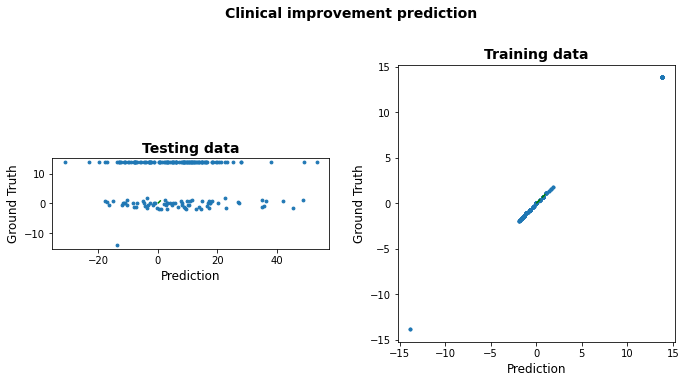

Coefficient of determination (R²):
     - testing  :     -4.23140913022018
     - training :     1.0


In [21]:
plot_results(model, X_test, y_test, X_train, y_train)

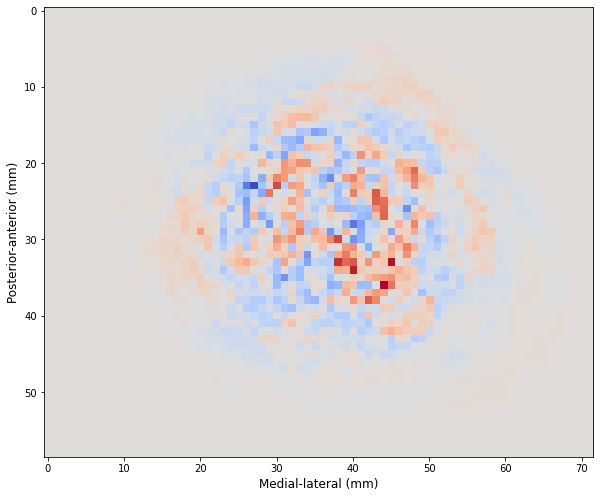

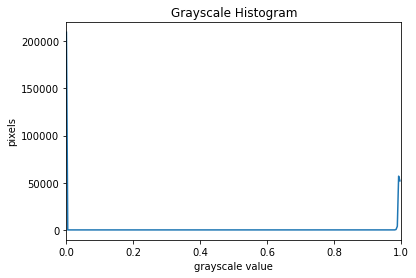

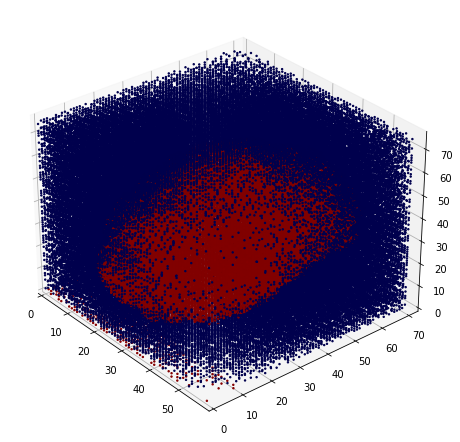

In [73]:
plot_map(model, dim='2D')
plot_map(model, dim='3D')

## Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 0.0001, max_iter=1e4)
model = model.fit(X_train, np.squeeze(y_train.T))

plot_results(model, X_test, y_test, X_train, y_train)


## Logistic Regression
Not possible because it relies on the Bernoulli distribution which is not applicable to a continuous variable as the clinical improvement. What we are looking for is more likely something like the beta-regression, which would model the distribution of the independant variable coming from a beta distribution.

## Bagging (SVR)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


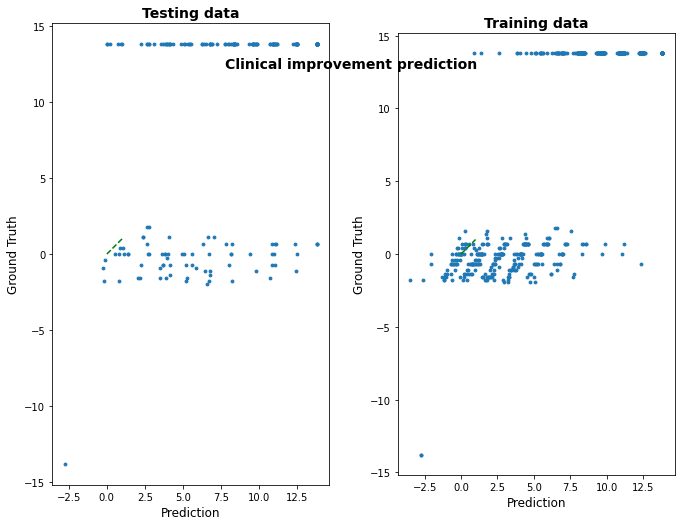

Coefficient of determination (R²):
     - testing  :     0.079087341015317
     - training :     0.7052847048635689


In [22]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

model = BaggingRegressor(n_estimators=10, random_state=0, verbose=1, max_samples=0.6,bootstrap_features=True, max_features=0.2)
model = model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

In [41]:
plot_map(model, dim='2D')

AttributeError: 'BaggingRegressor' object has no attribute 'coef_'

### Support Vector Regression

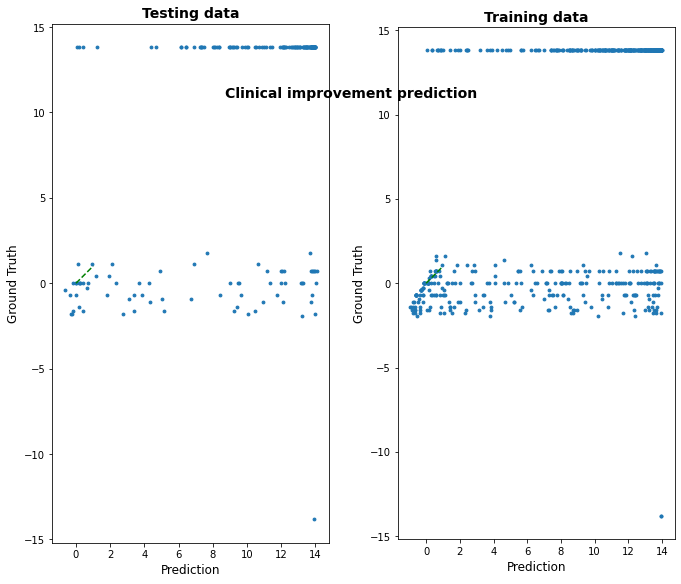

Coefficient of determination (R²):
     - testing  :     0.10200109948122882
     - training :     0.25263789142800974


In [23]:
from sklearn.svm import SVR
model = SVR(kernel='rbf')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

## Pipeline
### Dimensionality reduction

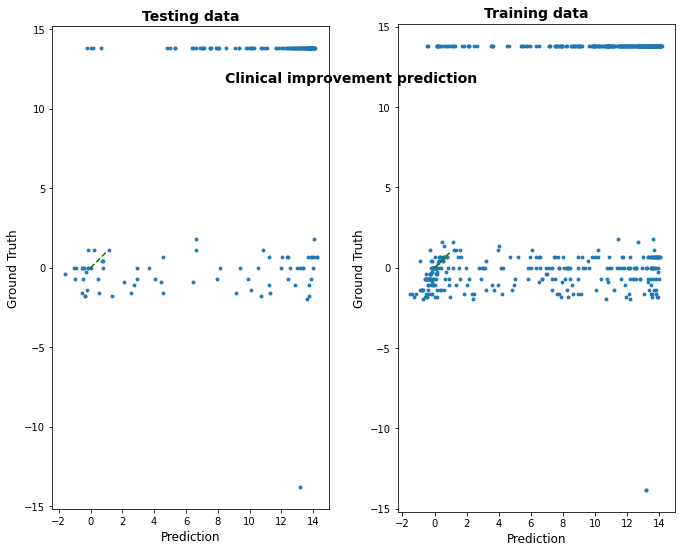

Coefficient of determination (R²):
     - testing  :     0.09500940410191316
     - training :     0.2288317932102134


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("reduce_dim", PCA(n_components=42)), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)

### Feature selection

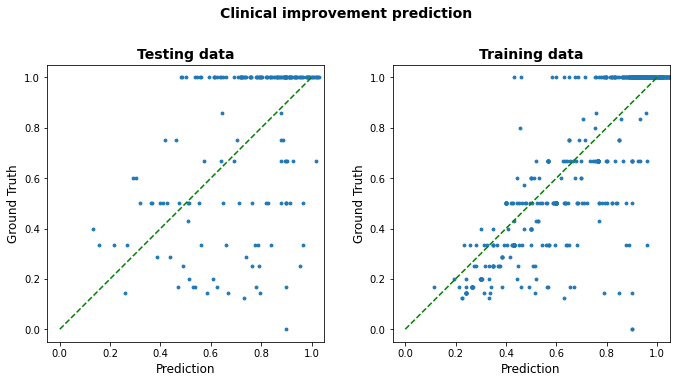

Coefficient of determination (R²):
     - testing  :     0.12026532035881043
     - training :     0.7661249606315896


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

steps = [("feature selection", SelectFromModel(estimator=Lasso(alpha = 0.005))
), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)
plot_map(model, dim='2D')

In [22]:
save_map(model)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from scipy.special import expit, logit

X, y, coef = make_regression(n_samples=1000,
                             n_features=5,
                             n_informative=3,
                             noise=5.0,
                             coef=True,
                             random_state=0)

# mapping the data to the interval [0,1]
y = expit(y/50)   # the factor 50 just scales the data appropriately

print("The data was generated with the following coefficients:")
print(coef)

The data was generated with the following coefficients:
[10.71453179  0.          0.         66.49948238 41.20593377]


In [25]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

feature_selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_selected_feat = feature_selection.fit_transform(X_train)

# feature_selection = Lasso(alpha = 0.005, max_iter=1e4)
# feature_selection.fit(X_train,y_train)

#plot_results(feature_selection, X_test, y_test, X_train, y_train)
#X_train_selected_feat = np.delete(X_train, np.where(feature_selection.coef_ == 0), 1)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(logLikelihood, x0=x0, args=(np.squeeze(y_train.T), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
y_ = expit(np.dot(X_train_selected_feat,b))             # predictions
plt.plot(y_, y_train, ".")

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


KeyboardInterrupt: 

In [68]:
b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
y_ = expit(np.dot(X_train_selected_feat,b))             # predictions
plt.plot(y_, y_train, ".")

ValueError: shapes (742,9982) and (105,) not aligned: 9982 (dim 1) != 105 (dim 0)

In [ ]:
from sklearn.feature_selection import RFE
